# OIH Editor Playground

For more background on the larger ODIS Ocean Info Hub and related referneces please visit out GitHub repository.


# Some package and imports

### pip installs

In [2]:
%%quiet
#!pip install -q gastrodon
#!pip install -q ontospy
!pip install -q anytree
!pip install -q PyJSONViewer
!pip install -q ConceptNet
!pip install -q qwikidata
!pip install -q SPARQLWrapper
!pip install -q Wikidata
!pip install -q pySHACL
!pip install 'PyLD>=2.0.3'


UsageError: Cell magic `%%quiet` not found.


### imports

In [3]:
#@title
# General imports
import json
import rdflib
import requests
from rdflib import Graph, plugin
from rdflib.serializer import Serializer
from bs4 import BeautifulSoup
import urllib.request

from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

# for JSON-LD work
from pyld import jsonld

# For SHACL
from pyshacl import validate

# concept net
import graphviz
from conceptnet5.uri import join_uri, split_uri
API_ROOT = 'http://api.conceptnet.io'



ModuleNotFoundError: No module named 'rdflib'

### functions

In [ ]:
import graphviz
from conceptnet5.uri import join_uri, split_uri
API_ROOT = 'http://api.conceptnet.io'


def short_name(value, max_length=40):
    """
    Convert an RDF value (given as a dictionary) to a reasonable label.
    """
    if value['type'] == 'blank node':
        return '_'
    elif value['type'] == 'IRI':    
        url = value['value']
        if '#' in url:
            # Show just the fragment of URLs with a fragment
            # (it's probably a property name)
            return url.split('#')[-1]

        # Give URLs relative to the root of our API
        if url.startswith(API_ROOT):
            short_url = url[len(API_ROOT):]
            # If the URL is too long, hide it
            if len(short_url) > max_length:
                pieces = split_uri(short_url)
                return join_uri(pieces[0], '...')
            else:
                return short_url
        else:
            return url.split('://')[-1]
    else:
        # Put literal values in quotes
        text = value['value'].replace(':', '')
        if len(text) > max_length:
            text = text[:max_length] + '...'
        return '"{}"'.format(text)

    
def show_graph(url, size=10):
    """
    Show the graph structure of a ConceptNet API response.
    """
    rdf = jsonld.normalize(url)['@default']
    graph = graphviz.Digraph(
        strict=False, graph_attr={'size': str(size), 'rankdir': 'LR'}
    )
    for edge in rdf:
        subj = short_name(edge['subject'])
        obj = short_name(edge['object'])
        pred = short_name(edge['predicate'])
        if subj and obj and pred:
            # Apply different styles to the nodes based on whether they're
            # literals, ConceptNet URLs, or other URLs
            if obj.startswith('"'):
                # Literal values
                graph.node(obj, penwidth='0')
            elif obj.startswith('/'):
                # ConceptNet nodes
                graph.node(obj, style='filled', fillcolor="#ddeeff")
            else:
                # Other URLs
                graph.node(obj, color="#558855")
            graph.edge(subj, obj, label=pred)
    
    return graph

In [ ]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

In [ ]:
# Fetch a single <1MB file using the raw GitHub URL.
!curl --remote-name \
     --location https://raw.githubusercontent.com/ESIPFed/science-on-schema.org/master/examples/dataset/full.jsonld

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10129  100 10129    0     0  49896      0 --:--:-- --:--:-- --:--:-- 49651


## Editor playground

In [ ]:
{
    "@context": {
        "@vocab": "https://schema.org/"
    },
    "@type": "CreativeWork",
    "@id": "https://example.org/id/XYZ",
    "name": "Name or title of the document",
    "description": "Description of the creative work to aid in searching",
    "url":  "https://www.sample-data-repository.org/creativework/report.pdf"
}

{'@context': {'@vocab': 'https://schema.org/'},
 '@id': 'https://example.org/id/XYZ',
 '@type': 'CreativeWork',
 'description': 'Description of the creative work to aid in searching',
 'name': 'Name or title of the document',
 'url': 'https://www.sample-data-repository.org/creativework/report.pdf'}

# Introduction to JSON-LD files


In [ ]:
#@title Google Data Set Required+

name = 'Data Set Name one' #@param {type:"string"}
sdotype = 'http://schema.org/Dataset' #@param ["http://schema.org/Dataset", "http://schema.org/DataCatalog"]
description = 'Descriptive text of the dataset.' #@param {type:"string"}
url = 'http://foo.org/data/distribution' #@param {type:"string"}
version = 'version' #@param {type:"string"}
license = 'CC-BY-4.0' #@param ["CC-BY-4.0", "CC-0"]
keywords = 'geochemistry, Earth System Modeling, climate change' #@param {type:"string"}


print(name)
print(description)


Data Set Name one
Descriptive text of the dataset.


In [ ]:
#@title
from pyld import jsonld
import json

doc = {}
doc["https://schema.org/name"] = name
doc["@type"] = sdotype
doc["@id"] = "http://cooldata.io/id/doc/1"
doc["https://schema.org/description"] = description
doc["https://schema.org/url"] =  url
doc["https://schema.org/version"] =  version
doc["https://schema.org/license"] =  license

# parse comma seperated keywords, clean white spaces
k = keywords.split(",")
kp = []
for i in k:
  j = i.strip()
  kp.append(j)

doc["http://schema.org/keywords"] =  kp


context = {
    "@vocab": "https://schema.org/",
}

# compact a document according to a particular context
# see: http://json-ld.org/spec/latest/json-ld/#compacted-document-form
compacted = jsonld.compact(doc, context)

jd = json.dumps(compacted, indent=4)
print(jd)

{
    "@context": {
        "@vocab": "https://schema.org/"
    },
    "@id": "http://cooldata.io/id/doc/1",
    "@type": "http://schema.org/Dataset",
    "http://schema.org/keywords": [
        "geochemistry",
        "Earth System Modeling",
        "climate change"
    ],
    "description": "Descriptive text of the dataset.",
    "license": "CC-BY-4.0",
    "name": "Data Set Name one",
    "url": "http://foo.org/data/distribution",
    "version": "version"
}


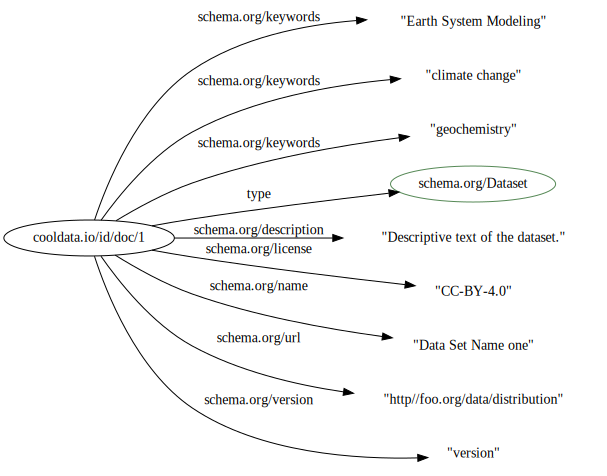

In [ ]:
show_graph(doc)

## Framing

Understanding Framing is not a first order concern.   However, understanding it and what it does can help you to think about how your data graph will be used. 

Let's make a frame that allows us to view only the elements of the JSON-LD data graph that we are interested in.   In this case let's target the keywords.

{'@context': {'@vocab': 'http://schema.org/'}, '@id': 'http://cooldata.io/id/doc/1', '@type': 'Dataset', 'keywords': ['geochemistry', 'Earth System Modeling', 'climate change']}


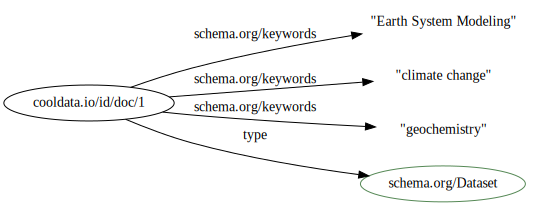

In [ ]:
urlf = "https://raw.githubusercontent.com/ESIPFed/science-on-schema.org/master/examples/dataset/minimal.jsonld"

frame = {
  "@context": {"@vocab": "http://schema.org/"},
  "@explicit": "true",
   "@type":     "Dataset",
  "keywords": "",
}


framed = jsonld.frame(doc, frame)
print(framed)

show_graph(framed)

### Parse out the keywords
At this point we can now take out resulting JSON-LD graph and extract the items we are interested int.


In [ ]:
#g = framed['@graph']  # get the graph
#kw = g[0]['keywords']  # get the keywords (you could do this in 1 line, 2 here for exposition)


kw = framed['keywords']  # get the keywords (you could do this in 1 line, 2 here for exposition)


print("We have the individual keywords, what shall we do with them?")
for w in kw:
  print(w)
  


We have the individual keywords, what shall we do with them?
geochemistry
Earth System Modeling
climate change


### Wikidata

So, we have used framing to arrive at a way to link to other graphs.  A nice use of framing but perhaps more important is the linking.  This exercise has shown how linking across graph gets us from strings to things.  

Let's see if we can query wikidata and pull back some concepts.    We will see if antyhing we use as a keyword aligns with a JSTOR (https://www.jstor.org/) topic.

Reference also: https://www.wikidata.org/wiki/Wikidata:WikidataCon_2019/Program/Sessions/Lightning_talks_2


In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import json

dbsparql = "http://dbpedia.org/sparql"
ufokn = "http://graph.openknowledge.network/blazegraph/namespace/demo/sparql"
wikidata = "https://query.wikidata.org/sparql"


In the example below we can BIND in keywords like geochemistry but also other terms we may extract from the name, keywords and description.  

In [ ]:
rq = '''SELECT ?term ?topic WHERE {{ BIND ( "{var}" as ?term ) ?topic wdt:P3827 ?term . }}'''.format(var="geochemistry")
test = get_sparql_dataframe(wikidata, rq)
test.head()

,term,topic
0,geochemistry,http://www.wikidata.org/entity/Q161764


In [ ]:
#df = pd.DataFrame(columns=['term', 'topic'])

for w in range(len(kw)):
  print(kw[w])
  rq = '''SELECT ?term ?topic WHERE {{ BIND ( "{var}" as ?term ) ?topic wdt:P3827 ?term . }}'''.format(var=kw[w])
  sdf = get_sparql_dataframe(wikidata, rq)
  #df.append(sdf)
  x = sdf.head()
  print(x)
  print("------------------------------------")
  
#df.head()
  


geochemistry
           term                                   topic
0  geochemistry  http://www.wikidata.org/entity/Q161764
------------------------------------
Earth System Modeling
Empty DataFrame
Columns: [term, topic]
Index: []
------------------------------------
climate change
Empty DataFrame
Columns: [term, topic]
Index: []
------------------------------------


In [ ]:
from wikidata.client import Client
from urllib.parse import urlparse

client = Client() 

for row in test.iterrows():
    o = urlparse(row[1]['topic'])
    e = o.path.rsplit('/', 1)[-1]
    entity = client.get('Q161764', load=True)
    print('---\nTerm:{} \nURL:{} \ndescription:{}'.format(row[1]['term'], row[1]['topic'],  entity.description))

---
Term:geochemistry 
URL:http://www.wikidata.org/entity/Q161764 
description:science that applies chemistry to geological systems


# Validation


## About
The code below invokes pySHACL on some data and shape graphs out of GitHub. Note, we could edit these local to this notebook too. The human output is a bit hard to read since some of the encoding is off.

It might actually work to use the graph output and route it through the graph package and into Pandas too. It might let us parse and present the results a bit better.

The imaage below is just a test of putting images into this document.  We can also upload and associate a document with the notebook and use it locally too.

![alt text](https://gleaner.io/images/tangram.png)

In [ ]:
from pyshacl import validate
import json
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import requests
from rdflib import Graph, plugin
from rdflib.serializer import Serializer

from bs4 import BeautifulSoup
import urllib.request

dg = 'https://raw.githubusercontent.com/ESIPFed/science-on-schema.org/master/examples/dataset/minimal.jsonld'
sg = 'https://raw.githubusercontent.com/geoschemas-org/geoshapes/master/shapegraphs/googleRecommendedCoverageCheck.ttl'

s = rdflib.Graph()
sr = s.parse(sg, format="ttl")
d = rdflib.Graph()
dr = d.parse(dg, format="json-ld")

conforms, v_graph, v_text = validate(dr, shacl_graph=sr,
  data_graph_format="json-ld",
  shacl_graph_format="ttl",
  inference='none', debug=False,
  serialize_report_graph=False)
        
print('{} {}'.format(conforms, v_text))


True Validation Report
Conforms: True



# Thematic topic: Documents

## About

A testing area for the work on type Document


In [ ]:
# Load examples from ODIS-Arch
!curl --remote-name \
     --location https://raw.githubusercontent.com/iodepo/odis-arch/master/schema/thematics/docs/graphs/doc.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0   2439      0 --:--:-- --:--:-- --:--:--  2439


In [ ]:
# read into var

with open('/content/doc.json', 'r') as file:
    docstring = file.read()

docjson = json.loads(docstring) 

# could I %load the file via magic commands?  see all via %lsmagic

### Dev note

During development  it would good to edit in the notebook and process the results through testing and viz.  So we have to edit the JSON in the notebook, which is hideous.

In [ ]:
{
    "@context": {
        "@vocab": "https://schema.org/"
    },
    "@id": "https://example.org/id/XYZ",
    "@type": "Dataset",
    "description": "Description of the dataset to aid in searching",
    "distribution": {
        "@type": "DataDownload",
        "contentUrl": "https://www.sample-data-repository.org/dataset/472032.tsv",
        "encodingFormat": "text/tab-separated-values"
    },
    "maintainer": {
        "@id": "https://link.to/PID_like_re3_or_others",
        "@type": "Organization",
        "description": "Organization or Person who maintains the creative work"
    },
    "name": "Name or title of the document",
    "subjectOf": {
        "@type": "DataDownload",
        "dateModified": "2019-06-12T14:44:15Z",
        "description": "EML metadata describing the dataset",
        "encodingFormat": [
            "application/xml",
            "https://eml.ecoinformatics.org/eml-2.2.0"
        ],
        "name": "eml-metadatafile.xml"
    }
}

{'@context': {'@vocab': 'https://schema.org/'},
 '@id': 'https://example.org/id/XYZ',
 '@type': 'Dataset',
 'description': 'Description of the dataset to aid in searching',
 'distribution': {'@type': 'DataDownload',
  'contentUrl': 'https://www.sample-data-repository.org/dataset/472032.tsv',
  'encodingFormat': 'text/tab-separated-values'},
 'maintainer': {'@id': 'https://link.to/PID_like_re3_or_others',
  '@type': 'Organization',
  'description': 'Organization or Person who maintains the creative work'},
 'name': 'Name or title of the document',
 'subjectOf': {'@type': 'DataDownload',
  'dateModified': '2019-06-12T14:44:15Z',
  'description': 'EML metadata describing the dataset',
  'encodingFormat': ['application/xml',
   'https://eml.ecoinformatics.org/eml-2.2.0'],
  'name': 'eml-metadatafile.xml'}}

In [ ]:

context = {
    "@vocab": "https://schema.org/",
}

# compact a document according to a particular context
# see: http://json-ld.org/spec/latest/json-ld/#compacted-document-form
compacted = jsonld.compact(_, context)  # CAUTION..  note _ which is reading the previous cell output...  

jd = json.dumps(compacted, indent=4)
print(jd)

{
    "@context": {
        "@vocab": "https://schema.org/"
    },
    "@id": "https://example.org/id/XYZ",
    "@type": "Dataset",
    "description": "Description of the dataset to aid in searching",
    "distribution": {
        "@type": "DataDownload",
        "contentUrl": "https://www.sample-data-repository.org/dataset/472032.tsv",
        "encodingFormat": "text/tab-separated-values"
    },
    "maintainer": {
        "@id": "https://link.to/PID_like_re3_or_others",
        "@type": "Organization",
        "description": "Organization or Person who maintains the creative work"
    },
    "name": "Name or title of the document",
    "subjectOf": {
        "@type": "DataDownload",
        "dateModified": "2019-06-12T14:44:15Z",
        "description": "EML metadata describing the dataset",
        "encodingFormat": [
            "application/xml",
            "https://eml.ecoinformatics.org/eml-2.2.0"
        ],
        "name": "eml-metadatafile.xml"
    }
}


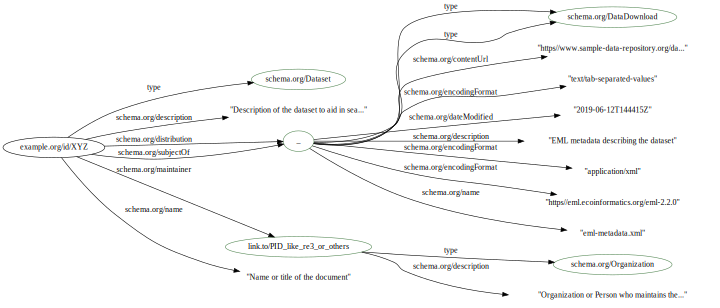

In [ ]:
show_graph(docjson)